<a href="https://colab.research.google.com/github/zulfikar2701/Sample-Project/blob/master/Hospital%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Loading Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/mimic3c.csv')

df = df.drop(['hadm_id'], axis=1)
print("No id",df.shape)

# data.head()
# data.info()

No id (58976, 27)


# Pre-Processing

Separate Numerical With Categorical

In [ ]:
numerical_features = ['age', 'LOSdays', 'NumCallouts', 'NumDiagnosis', 'NumProcs',
                      'NumCPTevents', 'NumInput', 'NumLabs', 'NumMicroLabs', 'NumNotes',
                      'NumOutput', 'NumRx', 'NumProcEvents', 'NumTransfers', 'NumChartEvents',
                      'TotalNumInteract']

categorical_features = ['gender', 'admit_type', 'admit_location', 'AdmitDiagnosis',
                        'insurance', 'religion', 'marital_status', 'ethnicity', 'AdmitProcedure']

target = 'ExpiredHospital'  # The target variable

Separate X and Y

In [ ]:
X = df[numerical_features + categorical_features]
y = df[target]

Do KNN Imputer, One-Hot Encoding and Scaler for Numerical Value (For standarization)

In [ ]:
# Preprocessing for numerical features (KNN imputer, scaling)
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features (imputing, encoding)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply the preprocessing pipeline to the training and test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

Unbalanced class for ExpiredHospital needs to do Oversampling Technique like SMOTE

Distribusi Class
ExpiredHospital
0    0.900739
1    0.099261
Name: count, dtype: float64


<ipython-input-6-8bcbebc53f85>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ExpiredHospital', data=df, palette = colors)


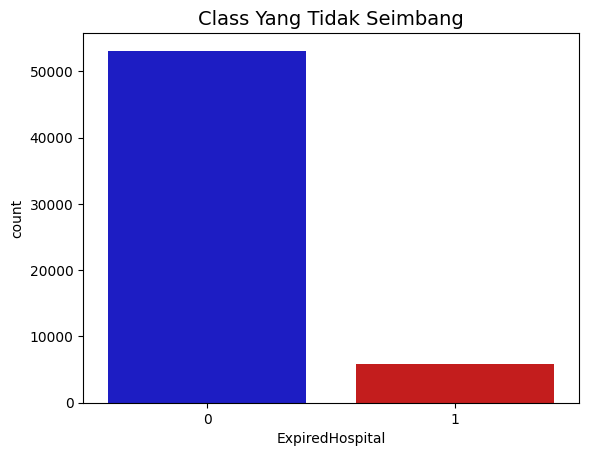

In [ ]:
colors = ["#0101DF", "#DF0101"]

print('Distribusi Class')
print(df['ExpiredHospital'].value_counts() / len(df))


sns.countplot(x='ExpiredHospital', data=df, palette = colors)
plt.title('Class Yang Tidak Seimbang', fontsize=14)
plt.show()


Menggunakan teknik oversampling SMOTE untuk membalance kolom ExpiredHospital

In [ ]:
smote = SMOTE(sampling_strategy='minority')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

Mencari n_component yang tepat untuk dimensionality reduction menggunakan TruncateSVD

Disini tidak memakai PCA karena bentuk data yang berbeda dengan requirement PCA (Dataframe vs Sparse Data)

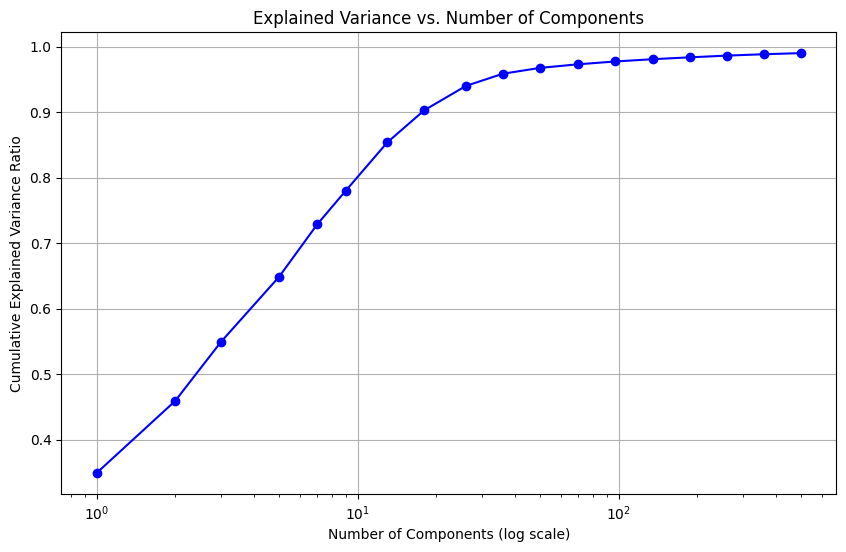

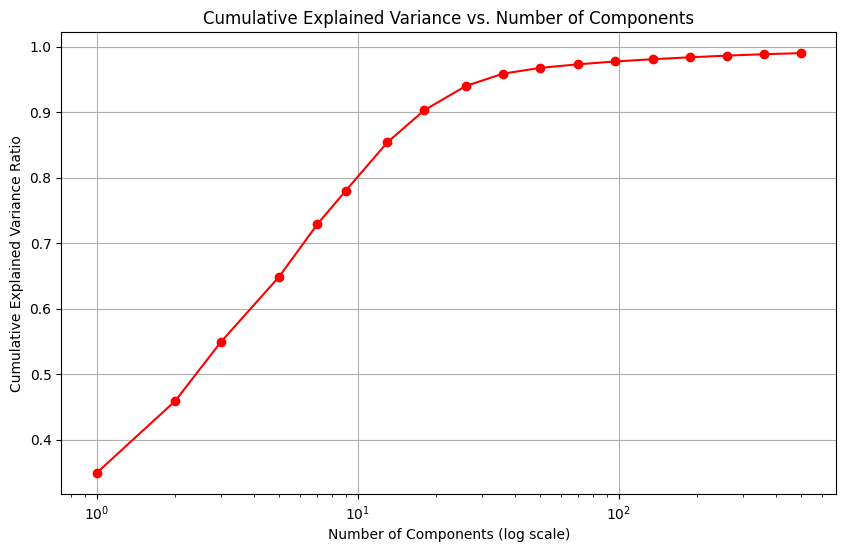

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed

# Sample a subset of data
X_sample, _, _, _ = train_test_split(X_train_resampled, y_train_resampled, train_size=0.3, random_state=42)

# Use logarithmic scale for component range
n_components_range = np.unique(np.logspace(0, np.log10(min(X_sample.shape[1], 500)), num=20, dtype=int))

def compute_variance(n_comp, X):
    svd = TruncatedSVD(n_components=n_comp, random_state=42)
    svd.fit(X)
    return svd.explained_variance_ratio_.sum(), np.cumsum(svd.explained_variance_ratio_)

# Parallel computation
results = Parallel(n_jobs=-1)(delayed(compute_variance)(n_comp, X_sample) for n_comp in n_components_range)

explained_variances, cumulative_variances = zip(*results)

# Plotting
plt.figure(figsize=(10, 6))
plt.semilogx(n_components_range, explained_variances, 'bo-')
plt.xlabel('Number of Components (log scale)')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.semilogx(n_components_range, [cv[-1] for cv in cumulative_variances], 'ro-')
plt.xlabel('Number of Components (log scale)')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

Didapat hasil components = 30 dari graph diatas

In [ ]:
svd = TruncatedSVD(n_components=30)
X_train_svd = svd.fit_transform(X_train_resampled)
X_test_svd = svd.transform(X_test_preprocessed)

In [ ]:
import os
if 'COLAB_TPU_ADDR' in os.environ:
    from tensorflow.distribute import TPUStrategy
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = TPUStrategy(resolver)
    print("TPU detected")
else:
    print("No TPU detected")

No TPU detected


In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


In [ ]:
# Define a smaller hyperparameter grid for faster processing
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings sampled
    cv=3,  # Fewer folds
    random_state=42,
    n_jobs=-1  # Use all available cores
)
random_search.fit(X_train_svd, y_train_resampled)

# Get the best model and its parameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Evaluate the best model on the test set
y_pred_best = best_model.predict(X_test_svd)
best_accuracy = accuracy_score(y_test, y_pred_best)

# Print the results
print(f'Best Accuracy: {best_accuracy:.5f}')
print('Best Model Parameters:')
print(best_params)
print('Best Model Classification Report:')
print(classification_report(y_test, y_pred_best))


Best Accuracy: 0.85351
Best Model Parameters:
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Best Model Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91     10629
           1       0.37      0.68      0.48      1167

    accuracy                           0.85     11796
   macro avg       0.67      0.78      0.70     11796
weighted avg       0.90      0.85      0.87     11796

